# **Modeling Notebook**

- This Notebook will be used for testing different models which will then be included in the final Vignette report.

We will be testing the following models:
- **Simple CNN**
    - 2 Convolution Layers with 64 layers each
    - Maxpooling
    - and a Dense Layer with 128 nodes with a dropout of 50%
- **Hyperband Parameter Training**
    - Uses Keras Hyperband Tuning to start with different architectures at lower epochs and slowly removes unpromising setups, and keeps the best ones and trains further
- **Pre-Trained Model with Dense Layers**
    - Resnet

Considerations:
- Do we need to consider a better data set?
- how can we get better performance?

In [1]:
##### library imports ##### 

# preprocessing and splitting data packages
import os
from Preprocessing import preprocess_data
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# modeling data packages
import keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall, AUC
from skimage.feature import graycomatrix, graycoprops
import pandas as pd

# set globalrandom seeds
np.random.seed(12345)
tf.random.set_seed(12345)
keras.utils.set_random_seed(12345)

# Preprocess Data from Preprocessing file

- Pulls Brain Tumor MRI images from each of 4 different classes, including:
    - Glioma
    - Meningioma  
    - Pituitary
    - Normal (no tumor)

- Ensures they are normalizes, resized, and Grayscaled for quicker computation

In [2]:
my_dir = os.getcwd()
print(f"Current working directory: {my_dir}")

# change this accordingly but should work for all users
glioma_path = my_dir[:-15] + "/data/glioma_tumor"
meningioma_path = my_dir[:-15] + "/data/meningioma_tumor"
pituitary_path = my_dir[:-15] + "/data/pituitary_tumor"
normal_path = my_dir[:-15] + "/data/no_tumor"

# preprocess data
glioma_data, glioma_labels = preprocess_data(glioma_path, 128)
meningioma_data, meningioma_labels = preprocess_data(meningioma_path, 128)
pituitary_data, pituitary_labels = preprocess_data(pituitary_path, 128)
normal_data, normal_labels = preprocess_data(normal_path, 128)

print("stacking data")
data = np.vstack([glioma_data, meningioma_data, pituitary_data, normal_data])
print("stacking labels")
labels = np.hstack([glioma_labels, meningioma_labels, pituitary_labels, normal_labels])

print("splitting data")
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=12345)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, shuffle=True, random_state=12345)

# one hot encode labels for all three sets
label_encoder = OneHotEncoder(sparse_output=False)
train_labels = label_encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
val_labels = label_encoder.transform(np.array(val_labels).reshape(-1, 1))
test_labels = label_encoder.transform(np.array(test_labels).reshape(-1, 1))

# Print shapes to verify split
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Test set shape: {test_data.shape}")

Current working directory: /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/scripts/drafts
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/glioma_tumor: 901
Processed 901 images.
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/meningioma_tumor: 913
Processed 913 images.
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/pituitary_tumor: 844
Processed 844 images.
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/no_tumor: 438
Processed 438 images.
stacking data
stacking labels
splitting data
Training set shape: (1857, 128, 128, 3)
Validation set shape: (619, 128, 128, 3)
Test set shape: (620, 128, 128, 3)


# Visually Inspect

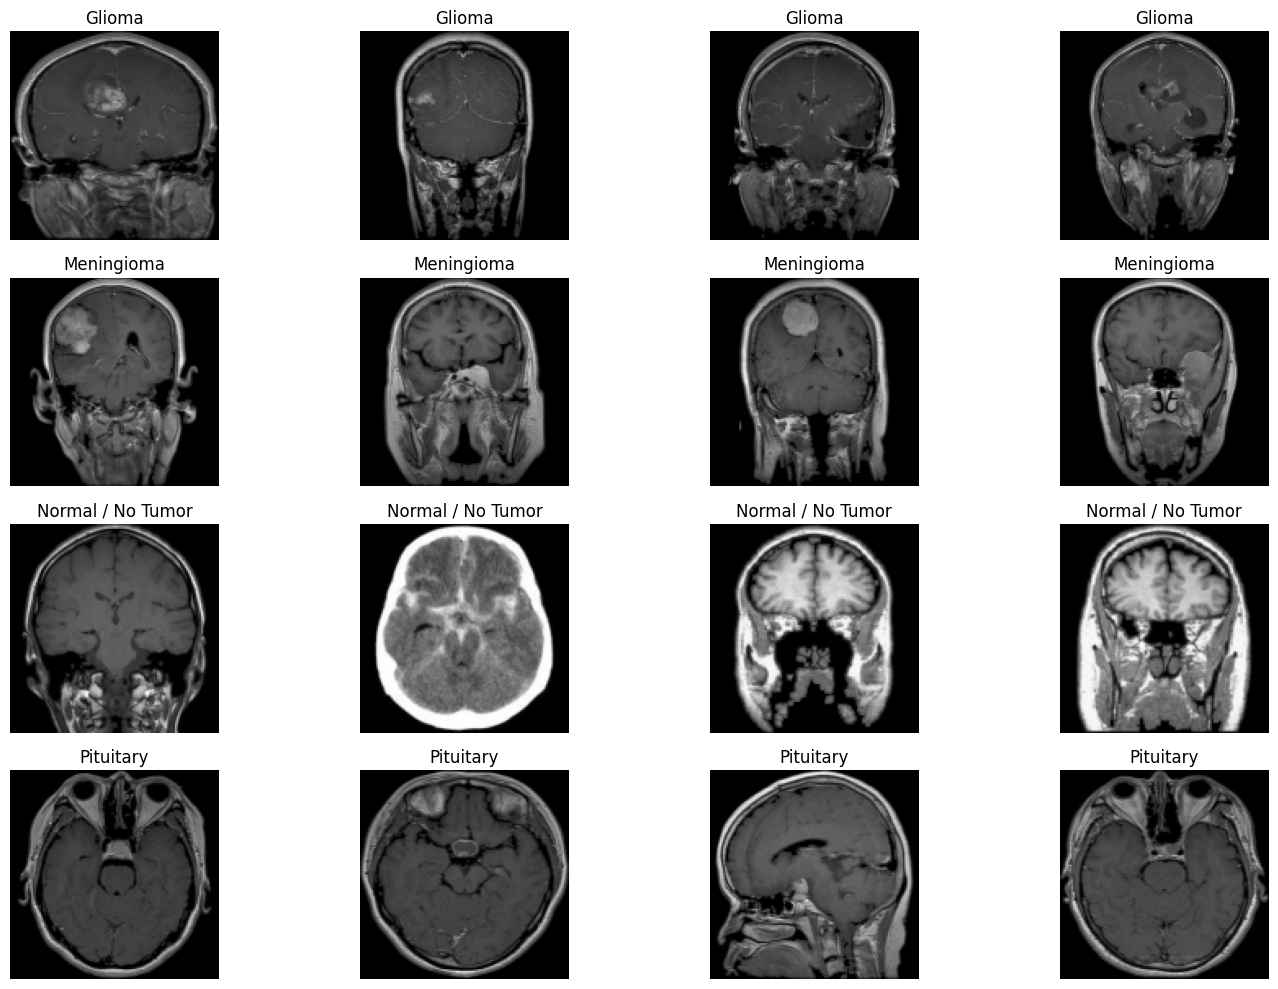

In [3]:
# show a few images from each class
unique_labels = np.unique(labels)
num_images_per_class = 4 # Number of images to display per class
plt.figure(figsize=(15, 10))  # Set figure size
for i, label in enumerate(unique_labels):
    class_indices = np.where(labels == label)[0]  # Get indices of images for the current label
    for j in range(num_images_per_class):
        if j < len(class_indices):  # Check if there are enough images for the class
            plt.subplot(len(unique_labels), num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(data[class_indices[j]], cmap='gray')  # Display the j-th image of the i-th class
            plt.axis('off')
            plt.title(str.capitalize(label) if label in ['glioma', 'meningioma', 'pituitary'] else 'Normal / No Tumor')
plt.tight_layout()
plt.show()

# Modeling
- ### We first can start with a simple convolution model as a base level to see how well one archictecture will learn on the training data set.
- ### Next, we will apply a hyperparameter tuning technique, called Hyperband tuning, to find the best setup.
     - Hyperband tuning performs a combination of random search and early stopping to efficiently explore hyperparameter configurations. It allocates resources to promising configurations while quickly discarding those that are underperforming, allowing for faster convergence to optimal hyperparameters.

# Simple CNN to Start

### What is a CNN?
A CNN (convolutional neural network) is a type of network that specializes in processing and predicting grid-like data, making it especially useful for image classification. It utilizes automatic detection of spatial hierarchies and patterns with layers of convolutional filters. Unlike the classic feed-forward network, which connects each neuron to every neuron in the next layer, a CNN uses local receptive fields and shared weights in its convolutional layers, which reduces the number of parameters significantly, and improves the efficiency of the model. 

### Model Flow
- In our example, the filters will pickup on different shapes, edges, and other patterns in the image, by sliding multiple 3x3 kernels convolving with the input image.
- After this we, apply a pooling function of either averaging or maximizing which typically halves the size of our convolved feature.
- Then after another round of convolving and maxpool, we flatten it and pass to a Dense neural network of hidden layers
- Finally the output layer is activated by a softmax function to provide us with probabilities of the classes. 

In [ ]:
# Initialize model
model = Sequential([
  Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 3)),
  MaxPooling2D(2), # reduce dimensionality
  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(2), # reduce dimensionality
  Flatten(), # flatten the data to feed into the dense layers
  Dense(units=128, activation='relu'),
  Dropout(0.5), # prevent overfitting
  Dense(units=4, activation='softmax') # output layer
])

model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

# Training the model

In [ ]:
# Train the model # 

# Early stopping will stop training when the validation loss stops improving for a few epochs, preventing overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=3, verbose=1, 
                               restore_best_weights=True)

history = model.fit(
    train_data,
    train_labels,
    validation_split=0.2, # Convert sparse matrix
    epochs=20,
    batch_size=32, # mini batch size
    callbacks=[early_stopping]
)

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()


# HyperParameter Tuning
- We will apply Hyperband Parameter Tuning to find our best set of params
- Then once we have the best set of hyperparams, we will build a final model and train with those parameters on the full training set.

In [20]:
# building a hyperband model to find the best model architecture
def build_model(hp):
    '''function to build a CNN model with a tuner object'''
    # initialize the model
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
               kernel_size=hp.Choice('conv_1_kernel', values=[3,4,5]),
               activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=64, max_value=256, step=32),
               kernel_size=hp.Choice('conv_2_kernel', values=[3,4,5]),
               activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=64, max_value=256, step=32),
               kernel_size=3,
               activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_1_units', min_value=128, max_value=1024, step=32),
              activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_2_units', min_value=128, max_value=512, step=32),
              activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(4, activation='softmax'))
    
    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']
    )
    return model

In [ ]:
# initialize tuner object
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy', # objective to optimize
    max_epochs=20, # how many epochs to train for once the best hyperparameters are found
    factor=5, # how many times to increase the number of epochs after the best hyperparameters are found
    directory=my_dir[:-15] + "/scripts/drafts/model_trials",
    project_name='hp_tuning',
    overwrite=False
)
# search for the best hyperparameters with the tuner object with an early stopping callback, and save the best model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(filepath=my_dir[:-15] + "/scripts/drafts/model_trials/hp_tuning/best_model.keras", 
                             save_best_only=True, save_weights_only=True)
tuner.search(
    train_data, train_labels,
    epochs=20,
    batch_size=32, 
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

# Get the best hyperparameters directly
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hp.values)

# build the best model
Hyperband_model = tuner.hypermodel.build(best_hp)
Hyperband_model.load_weights(my_dir[:-15] + "/scripts/drafts/model_trials/hp_tuning/best_model.keras")
Hyperband_model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'AUC'])

Once we have our best model, we can then build using the best architecture and train on the full data set.

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# evaluate the best model on the test set
Hyperband_test_loss, Hyperband_test_accuracy, Hyperband_test_auc = Hyperband_model.evaluate(test_data, test_labels)
print(f"Test Loss: {Hyperband_test_loss}")
print(f"Test Accuracy: {Hyperband_test_accuracy}")
print(f"Test AUC: {Hyperband_test_auc}")

from sklearn.metrics import confusion_matrix
# confusion matrix
y_pred = Hyperband_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert test_labels from one-hot encoding to single class format
test_labels_classes = np.argmax(test_labels, axis=1)

print(confusion_matrix(test_labels_classes, y_pred_classes))

# Transfer Learning with ResNet50V2

- We can enhance the model by using transfer learning which uses a pre-trained models weights and architecture to help predict on our data.
- We will customize our model by playing around with the pre-trained layers by freezing and unfreezing.

### **Strategy** 
One strategy used below includes "freezing" the pre-trained model's training layers until the model stops improving with respect to the loss function (or some other metric), which then we can unfreeze the models layers, and start to train the last layer of the pre-trained model on our particular data set.

In [3]:
# show layer names of the pre-trained model
# Use ResNet50V2 from keras.application as pre trained model with imagenet weight
# we dont include the top layer as we will be building our own dense layers. Top layer is the output layer.
pre_trained_model = keras.applications.ResNet50V2(
    weights='imagenet', classes=4, input_shape=(128, 128, 3), include_top=False
)
# display model summary
pre_trained_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 34, 34,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

## Building a new model from transfer learning

In [5]:
train_labels

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [7]:
def build_model(pre_trained_model):
    '''
    Builds a model with a pre-trained model of the users choice,
    then builds on with dense layers to train on the particular dataset.
    '''
    model = Sequential()
    model.add(pre_trained_model)  # Add the pre-trained model
    model.add(GlobalAveragePooling2D()) # global average pooling to reduce dimensionality
    model.add(Dense(units=1024, activation='relu'))  # Dense layer with 1024 nodes
    model.add(Dropout(0.3))
    model.add(Dense(units=512, activation='relu'))  # Dense layer with 512 nodes
    model.add(Dropout(0.3))
    model.add(Dense(units=256, activation='relu')) # Dense layer with 256 nodes
    model.add(Dropout(0.3))
    model.add(Dense(units=128, activation='relu')) # Dense layer with 128 nodes
    model.add(Dropout(0.3))
    model.add(Dense(units=4, activation='softmax'))  # Output layer with 4 nodes

    # Compile the model
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'AUC'])
    return model

In [8]:
# Load the pre-trained ResNet50V2 model
base_model = keras.applications.ResNet50V2(include_top=False, input_shape=(128, 128, 3), weights='imagenet')

# Freeze layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build and train the initial model
pre_trained_model = build_model(base_model)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
callbacks = [early_stopping, reduce_lr]

# Train frozen base model
history = pre_trained_model.fit(train_data, train_labels, 
                    epochs=50,
                    validation_data=(val_data, val_labels),  
                    batch_size=32,
                    callbacks=callbacks)

# Unfreeze the last few layers for fine-tuning
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block3_preact_bn':  # Start unfreezing from this layer onward
        set_trainable = True
    layer.trainable = set_trainable
    if isinstance(layer, BatchNormalization):  # Keep BatchNormalization layers frozen
        layer.trainable = False

# Compile with a smaller learning rate for fine-tuning
pre_trained_model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC'])

# Continue training with unfrozen layers
history_fine_tune = pre_trained_model.fit(train_data, train_labels, 
                              epochs=50,
                              validation_data=(val_data, val_labels),  
                              batch_size=32,
                              callbacks=callbacks)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 25s 381ms/step - AUC: 0.6649 - accuracy: 0.4043 - loss: 1.6548 - val_AUC: 0.8825 - val_accuracy: 0.6624 - val_loss: 0.8347 - learning_rate: 0.0010
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - AUC: 0.8613 - accuracy: 0.6188 - loss: 0.9063 - val_AUC: 0.9077 - val_accuracy: 0.6898 - val_loss: 0.7385 - learning_rate: 0.0010
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - AUC: 0.9126 - accuracy: 0.7087 - loss: 0.7240 - val_AUC: 0.9278 - val_accuracy: 0.7334 - val_loss: 0.6572 - learning_rate: 0.0010
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - AUC: 0.9481 - accuracy: 0.7862 - loss: 0.5452 - val_AUC: 0.9446 - val_accuracy: 0.7835 - val_loss: 0.5811 - learning_rate: 0.0010
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 414ms/step - AUC: 0.9571 - accuracy: 0.8084 - loss: 0.4985 - val_AUC: 0.9507 - val_accuracy: 0.8191 - val_loss: 0.5380 - learning_rate: 0.0010
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 406ms/step - AUC: 0.9711 - accura

In [9]:
# evaluate on test set
test_loss, test_accuracy, test_auc = pre_trained_model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - AUC: 0.9570 - accuracy: 0.8339 - loss: 0.5733
Test Loss: 0.535885751247406
Test Accuracy: 0.8370967507362366
Test AUC: 0.961246907711029
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step


NameError: name 'confusion_matrix' is not defined

# report of which classes the model is most confident in

In [18]:
from sklearn.metrics import classification_report
y_pred = pre_trained_model.predict(test_data)
test_labels_classes = label_encoder.inverse_transform(test_labels)
y_pred_classes = label_encoder.inverse_transform(y_pred)
print(classification_report(test_labels_classes, y_pred_classes))

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step
              precision    recall  f1-score   support

      glioma       0.85      0.85      0.85       195
  meningioma       0.76      0.74      0.75       175
          no       0.93      0.88      0.90        85
   pituitary       0.86      0.90      0.88       165

    accuracy                           0.84       620
   macro avg       0.85      0.84      0.85       620
weighted avg       0.84      0.84      0.84       620

